# Experimentación - MTGNN



## 1. Obtención de datos



In [1]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import MTGNNModel
from utils.trainer import  TrainerMTGNN
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [8]:
def entrenar_y_evaluar_modelos_mtgnn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None, device=torch.device("cpu")):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]

    device = device
    n_iter = 50 

    for _ in tqdm(range(n_iter)):
        gcn_depth = random.choice(param_grid['gcn_depth'])
        conv_channels = random.choice(param_grid['conv_channels'])
        kernel_size = random.choice(param_grid['kernel_size'])
        dropout = random.choice(param_grid['dropout'])
        gcn_true = random.choice(param_grid['gcn_true'])
        build_adj = random.choice(param_grid['build_adj'])
        propalpha = random.choice(param_grid['propalpha'])
        out_channels = random.choice(param_grid['out_channels'])

           
        print(f"Entrenando modelo con gcn_depth={gcn_depth}, conv_channels={conv_channels}, kernel_size={kernel_size}, dropout={dropout}, gcn_true={gcn_true}, build_adj={build_adj}, propalpha={propalpha}, out_channels={out_channels}")
        model = MTGNNModel(
            name="MTGNN", 
            node_count=n_nodes, 
            node_features=n_features, 
            n_target=n_target,
            conv_channels=conv_channels,
            residual_channels=conv_channels, 
            out_channels=out_channels,
            skip_channels=conv_channels // 2,  # Ejemplo de cómo definir skip channels
            end_channels=n_target,  # Para conectar con la salida
            gcn_depth=gcn_depth,
            kernel_size=kernel_size,
            dropout=dropout,
            gcn_true=gcn_true,
            build_adj=build_adj,
            propalpha=propalpha,
            is_classification=True
        )
        trainer = TrainerMTGNN(model, dataset, device, f"./results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
                "gcn_depth": gcn_depth,
            "conv_channels": conv_channels,
            "kernel_size": kernel_size,
            "dropout": dropout,
            "gcn_true": gcn_true,
            "build_adj": build_adj,
            "propalpha": propalpha,
            "out_channels": out_channels,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
    
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {
                "gcn_depth": gcn_depth,
                "conv_channels": conv_channels,
                "kernel_size": kernel_size,
                "dropout": dropout,
                "gcn_true": gcn_true,
                "build_adj": build_adj,
                "propalpha": propalpha,
                "out_channels": out_channels
            }
            mejores_resultados = results_intermedio

        print("Resultados: ", resultados_list[-1])
        
    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [10]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MTGNNModel

In [11]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerMTGNN

In [12]:

param_grid = {
    'gcn_depth': [1,2, 3],                  
    'conv_channels': [4, 8, 16], 
    'out_channels': [4, 8, 16],          
    'kernel_size': [3],                
    'dropout': [0.25],              
    'gcn_true': [True],                
    'build_adj': [True],              
    'propalpha': [0.15]            
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": True
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_mtgnn(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "MTGNN",target_names)

  0%|          | 0/50 [00:00<?, ?it/s]

Entrenando modelo con gcn_depth=2, conv_channels=4, kernel_size=3, dropout=0.25, gcn_true=True, build_adj=True, propalpha=0.15, out_channels=16

==================== DATASET INFO ===================

Train dataset: 384
Validation dataset: 82
Test dataset: 83

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5841 | Eval Loss: 1.5686 | Accuracy: 0.3780 | Precision: 0.0756 | Recall: 0.2000 | F1-Score: 0.1097 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5766 | Eval Loss: 1.5610 | Accuracy: 0.3780 | Precision: 0.0756 | Recall: 0.2000 | F1-Score: 0.1097 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.5723 | Eval Loss: 1.5544 | Accuracy: 0.3780 | Precision: 0.0756 | Recall: 0.2000 | F1-Score: 0.1097 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.5690 | Eval Loss: 1.5492 | Accuracy: 0.3780 | Precision: 0.0756 | Recall: 0.2000 | F1-Score: 0.1097 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.5667 | Eval Loss: 1.5451 | Accuracy: 0.3780 | Precision: 0.0756 | Recall: 0.2000 | 

  2%|▏         | 1/50 [08:48<7:11:27, 528.31s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.550922, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 2, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.561545968055725, 'Accuracy_eval': 0.3780487804878049, 'Precision_eval': 0.07560975609756099, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1097345132743363, 'Loss_eval': 1.5394150018692017, 'Loss_t

  4%|▍         | 2/50 [51:26<22:58:06, 1722.63s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.555435, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.576008915901184, 'Accuracy_eval': 0.3780487804878049, 'Precision_eval': 0.07560975609756099, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1097345132743363, 'Loss_eval': 1.5267835855484009, 'Loss_t

  6%|▌         | 3/50 [1:13:06<19:58:10, 1529.57s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00        15
           2       0.50      0.11      0.18         9
           3       0.95      0.95      0.95        19
           4       0.64      1.00      0.78        29

    accuracy                           0.71        83
   macro avg       0.55      0.61      0.54        83
weighted avg       0.58      0.71      0.61        83

preds:  torch.Size([])
test loss: 1.227386, test accuracy: 0.7108, test precision: 0.5478, test recall: 0.6117, test F1-score: 0.5397
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.2690916061401367, 'Accuracy_eval': 0.576688555347092, 'Precision_eval': 0.3359757546565069, 'Recall_eval': 0.4437203003616667, 'F1_eval': 0.35834868034897305, 'Loss_eval': 1.2331613302230835, 'Loss_tst

  8%|▊         | 4/50 [1:28:57<16:37:34, 1301.19s/it]

              precision    recall  f1-score   support

           0       0.54      0.64      0.58        11
           1       0.00      0.00      0.00        15
           2       0.29      0.22      0.25         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.46        83
   macro avg       0.26      0.37      0.29        83
weighted avg       0.26      0.46      0.32        83

preds:  torch.Size([])
test loss: 1.436849, test accuracy: 0.4578, test precision: 0.2569, test recall: 0.3717, test F1-score: 0.2928
Resultados:  {'gcn_depth': 1, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.3601815700531006, 'Accuracy_eval': 0.5408067542213885, 'Precision_eval': 0.2620921375903249, 'Recall_eval': 0.3629864253393664, 'F1_eval': 0.28407943954601383, 'Loss_eval': 1.3223838806152344, 'Loss_t

 10%|█         | 5/50 [1:38:19<12:55:53, 1034.53s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.67      0.67      0.67        15
           2       0.00      0.00      0.00         9
           3       0.88      0.79      0.83        19
           4       0.74      0.86      0.79        29

    accuracy                           0.73        83
   macro avg       0.59      0.66      0.62        83
weighted avg       0.67      0.73      0.69        83

preds:  torch.Size([])
test loss: 1.294205, test accuracy: 0.7349, test precision: 0.5863, test recall: 0.6636, test F1-score: 0.6159
Resultados:  {'gcn_depth': 3, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.2535114288330078, 'Accuracy_eval': 0.4322232645403377, 'Precision_eval': 0.3101432987370289, 'Recall_eval': 0.4552119722992589, 'F1_eval': 0.3237740914810043, 'Loss_eval': 1.2858773469924927, 'Loss_tst

 12%|█▏        | 6/50 [1:54:38<12:24:46, 1015.60s/it]

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.38      0.80      0.51        15
           2       0.29      0.22      0.25         9
           3       0.00      0.00      0.00        19
           4       0.78      0.86      0.82        29

    accuracy                           0.55        83
   macro avg       0.41      0.50      0.44        83
weighted avg       0.45      0.55      0.49        83

preds:  torch.Size([])
test loss: 1.354572, test accuracy: 0.5542, test precision: 0.4051, test recall: 0.5041, test F1-score: 0.4378
Resultados:  {'gcn_depth': 1, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2052907943725586, 'Accuracy_eval': 0.5802063789868668, 'Precision_eval': 0.3285354533976239, 'Recall_eval': 0.42374032987884974, 'F1_eval': 0.3562704062752301, 'Loss_eval': 1.275261640548706, 'Loss_ts

 14%|█▍        | 7/50 [2:42:20<19:20:23, 1619.15s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.39      0.78      0.52         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.43        83
   macro avg       0.17      0.36      0.23        83
weighted avg       0.20      0.43      0.27        83

preds:  torch.Size([])
test loss: 1.470930, test accuracy: 0.4337, test precision: 0.1670, test recall: 0.3556, test F1-score: 0.2271
Resultados:  {'gcn_depth': 3, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.4360624551773071, 'Accuracy_eval': 0.522279549718574, 'Precision_eval': 0.19730734469510305, 'Recall_eval': 0.3576923076923077, 'F1_eval': 0.25380463154983257, 'Loss_eval': 1.3672720193862915, 'Loss_t

 16%|█▌        | 8/50 [2:52:06<15:03:15, 1290.36s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.90      1.00      0.95        19
           4       0.64      1.00      0.78        29

    accuracy                           0.71        83
   macro avg       0.44      0.60      0.50        83
weighted avg       0.52      0.71      0.60        83

preds:  torch.Size([])
test loss: 1.213512, test accuracy: 0.7108, test precision: 0.4393, test recall: 0.6000, test F1-score: 0.5039
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2597074508666992, 'Accuracy_eval': 0.6102251407129456, 'Precision_eval': 0.35383107967415495, 'Recall_eval': 0.47390421511863645, 'F1_eval': 0.38282174008807507, 'Loss_eval': 1.2193655967712402, 'Loss

 18%|█▊        | 9/50 [3:12:32<14:27:57, 1270.18s/it]

              precision    recall  f1-score   support

           0       0.53      0.91      0.67        11
           1       0.50      0.67      0.57        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.66      1.00      0.79        29

    accuracy                           0.59        83
   macro avg       0.34      0.52      0.41        83
weighted avg       0.39      0.59      0.47        83

preds:  torch.Size([])
test loss: 1.330399, test accuracy: 0.5904, test precision: 0.3371, test recall: 0.5152, test F1-score: 0.4065
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2991023063659668, 'Accuracy_eval': 0.5480769230769231, 'Precision_eval': 0.23919962504801087, 'Recall_eval': 0.3817622731474723, 'F1_eval': 0.2852326587509996, 'Loss_eval': 1.2773816585540771, 'Loss_t

 20%|██        | 10/50 [3:53:39<18:13:07, 1639.68s/it]

              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.44      0.73      0.55        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      1.00      0.83        29

    accuracy                           0.60        83
   macro avg       0.35      0.53      0.42        83
weighted avg       0.40      0.60      0.48        83

preds:  torch.Size([])
test loss: 1.350873, test accuracy: 0.6024, test precision: 0.3471, test recall: 0.5285, test F1-score: 0.4186
Resultados:  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.3102294206619263, 'Accuracy_eval': 0.5898217636022514, 'Precision_eval': 0.28968217739912017, 'Recall_eval': 0.4391813036215313, 'F1_eval': 0.3413270287923042, 'Loss_eval': 1.2921762466430664, 'Loss_t

 22%|██▏       | 11/50 [4:35:37<20:40:35, 1908.62s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.555435, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.576008915901184, 'Accuracy_eval': 0.3780487804878049, 'Precision_eval': 0.07560975609756099, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1097345132743363, 'Loss_eval': 1.5267835855484009, 'Loss_

 24%|██▍       | 12/50 [4:42:52<15:24:50, 1460.28s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.90      1.00      0.95        19
           4       0.64      1.00      0.78        29

    accuracy                           0.71        83
   macro avg       0.44      0.60      0.50        83
weighted avg       0.52      0.71      0.60        83

preds:  torch.Size([])
test loss: 1.213512, test accuracy: 0.7108, test precision: 0.4393, test recall: 0.6000, test F1-score: 0.5039
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2597074508666992, 'Accuracy_eval': 0.6102251407129456, 'Precision_eval': 0.35383107967415495, 'Recall_eval': 0.47390421511863645, 'F1_eval': 0.38282174008807507, 'Loss_eval': 1.2193655967712402, 'Loss

 26%|██▌       | 13/50 [4:50:06<11:48:41, 1149.24s/it]

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       0.00      0.00      0.00        15
           2       0.75      0.33      0.46         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.52        83
   macro avg       0.38      0.47      0.38        83
weighted avg       0.33      0.52      0.38        83

preds:  torch.Size([])
test loss: 1.413092, test accuracy: 0.5181, test precision: 0.3796, test recall: 0.4667, test F1-score: 0.3814
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.3825974464416504, 'Accuracy_eval': 0.553705440900563, 'Precision_eval': 0.23147673945815375, 'Recall_eval': 0.3696983408748115, 'F1_eval': 0.2740202417490639, 'Loss_eval': 1.3228542804718018, 'Loss_tst

 28%|██▊       | 14/50 [5:05:23<10:47:29, 1079.16s/it]

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.38      0.80      0.51        15
           2       0.29      0.22      0.25         9
           3       0.00      0.00      0.00        19
           4       0.78      0.86      0.82        29

    accuracy                           0.55        83
   macro avg       0.41      0.50      0.44        83
weighted avg       0.45      0.55      0.49        83

preds:  torch.Size([])
test loss: 1.354572, test accuracy: 0.5542, test precision: 0.4051, test recall: 0.5041, test F1-score: 0.4378
Resultados:  {'gcn_depth': 1, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2052907943725586, 'Accuracy_eval': 0.5802063789868668, 'Precision_eval': 0.3285354533976239, 'Recall_eval': 0.42374032987884974, 'F1_eval': 0.3562704062752301, 'Loss_eval': 1.275261640548706, 'Loss_ts

 30%|███       | 15/50 [5:25:14<10:49:11, 1112.91s/it]

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.48        83
   macro avg       0.20      0.40      0.27        83
weighted avg       0.23      0.48      0.31        83

preds:  torch.Size([])
test loss: 1.421696, test accuracy: 0.4819, test precision: 0.2021, test recall: 0.4000, test F1-score: 0.2680
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.4089248180389404, 'Accuracy_eval': 0.5590994371482177, 'Precision_eval': 0.21940844345484578, 'Recall_eval': 0.3746606334841628, 'F1_eval': 0.2755566140814531, 'Loss_eval': 1.3301435708999634, 'Loss_ts

 32%|███▏      | 16/50 [6:09:45<14:56:26, 1581.96s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.92      0.73      0.81        15
           2       0.00      0.00      0.00         9
           3       0.95      1.00      0.97        19
           4       0.85      1.00      0.92        29

    accuracy                           0.84        83
   macro avg       0.67      0.75      0.70        83
weighted avg       0.77      0.84      0.80        83

preds:  torch.Size([])
test loss: 1.064711, test accuracy: 0.8434, test precision: 0.6733, test recall: 0.7467, test F1-score: 0.6991
Resultados:  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.105075478553772, 'Accuracy_eval': 0.6207786116322702, 'Precision_eval': 0.4123253845640709, 'Recall_eval': 0.5203542872897713, 'F1_eval': 0.4463903039433494, 'Loss_eval': 1.1640194654464722, 'Loss_ts

 34%|███▍      | 17/50 [6:19:42<11:47:11, 1285.80s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.90      1.00      0.95        19
           4       0.64      1.00      0.78        29

    accuracy                           0.71        83
   macro avg       0.44      0.60      0.50        83
weighted avg       0.52      0.71      0.60        83

preds:  torch.Size([])
test loss: 1.291013, test accuracy: 0.7108, test precision: 0.4393, test recall: 0.6000, test F1-score: 0.5039
Resultados:  {'gcn_depth': 3, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.3237189054489136, 'Accuracy_eval': 0.5445590994371483, 'Precision_eval': 0.2478227857757858, 'Recall_eval': 0.4190363126226505, 'F1_eval': 0.3033174896070596, 'Loss_eval': 1.2773921489715576, 'Loss_tst

 36%|███▌      | 18/50 [6:28:18<9:22:19, 1054.37s/it] 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.553432, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 2, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.5621567964553833, 'Accuracy_eval': 0.3367729831144466, 'Precision_eval': 0.06735459662288931, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.09960629644965018, 'Loss_eval': 1.5343973636627197, 'Loss_

 38%|███▊      | 19/50 [6:35:39<7:29:39, 870.31s/it] 

              precision    recall  f1-score   support

           0       0.40      0.91      0.56        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.50      1.00      0.67        29

    accuracy                           0.47        83
   macro avg       0.18      0.38      0.24        83
weighted avg       0.23      0.47      0.31        83

preds:  torch.Size([])
test loss: 1.397493, test accuracy: 0.4699, test precision: 0.1800, test recall: 0.3818, test F1-score: 0.2444
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.3652288913726807, 'Accuracy_eval': 0.5241557223264541, 'Precision_eval': 0.18779809162423391, 'Recall_eval': 0.34105240110932705, 'F1_eval': 0.23986789621077045, 'Loss_eval': 1.3055957555770874, 'Loss_

 40%|████      | 20/50 [6:42:49<6:08:58, 737.96s/it]

              precision    recall  f1-score   support

           0       0.40      0.91      0.56        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.50      1.00      0.67        29

    accuracy                           0.47        83
   macro avg       0.18      0.38      0.24        83
weighted avg       0.23      0.47      0.31        83

preds:  torch.Size([])
test loss: 1.397493, test accuracy: 0.4699, test precision: 0.1800, test recall: 0.3818, test F1-score: 0.2444
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.3652288913726807, 'Accuracy_eval': 0.5241557223264541, 'Precision_eval': 0.18779809162423391, 'Recall_eval': 0.34105240110932705, 'F1_eval': 0.23986789621077045, 'Loss_eval': 1.3055957555770874, 'Loss_

 42%|████▏     | 21/50 [7:32:04<11:18:23, 1403.55s/it]

              precision    recall  f1-score   support

           0       0.53      0.82      0.64        11
           1       0.39      0.73      0.51        15
           2       0.33      0.11      0.17         9
           3       0.00      0.00      0.00        19
           4       0.69      0.83      0.75        29

    accuracy                           0.54        83
   macro avg       0.39      0.50      0.41        83
weighted avg       0.42      0.54      0.46        83

preds:  torch.Size([])
test loss: 1.359712, test accuracy: 0.5422, test precision: 0.3883, test recall: 0.4980, test F1-score: 0.4142
Resultados:  {'gcn_depth': 3, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.214683175086975, 'Accuracy_eval': 0.574343339587242, 'Precision_eval': 0.3455578084875483, 'Recall_eval': 0.46777356103731815, 'F1_eval': 0.3810137581742338, 'Loss_eval': 1.2934231758117676, 'Loss_tst

 44%|████▍     | 22/50 [7:53:12<10:35:56, 1362.75s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.41      0.73      0.52        15
           2       0.33      0.67      0.44         9
           3       0.00      0.00      0.00        19
           4       0.66      0.86      0.75        29

    accuracy                           0.51        83
   macro avg       0.28      0.45      0.34        83
weighted avg       0.34      0.51      0.40        83

preds:  torch.Size([])
test loss: 1.406238, test accuracy: 0.5060, test precision: 0.2797, test recall: 0.4524, test F1-score: 0.3429
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.2905242443084717, 'Accuracy_eval': 0.5046904315196998, 'Precision_eval': 0.27590917150806926, 'Recall_eval': 0.4284615384615384, 'F1_eval': 0.33050560660967654, 'Loss_eval': 1.3436036109924316, 'Loss_t

 46%|████▌     | 23/50 [8:39:25<13:23:41, 1785.99s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.92      0.73      0.81        15
           2       0.00      0.00      0.00         9
           3       0.95      1.00      0.97        19
           4       0.85      1.00      0.92        29

    accuracy                           0.84        83
   macro avg       0.67      0.75      0.70        83
weighted avg       0.77      0.84      0.80        83

preds:  torch.Size([])
test loss: 1.064711, test accuracy: 0.8434, test precision: 0.6733, test recall: 0.7467, test F1-score: 0.6991
Resultados:  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.105075478553772, 'Accuracy_eval': 0.6207786116322702, 'Precision_eval': 0.4123253845640709, 'Recall_eval': 0.5203542872897713, 'F1_eval': 0.4463903039433494, 'Loss_eval': 1.1640194654464722, 'Loss_ts

 48%|████▊     | 24/50 [8:47:29<10:04:35, 1395.20s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.550645, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.5624048709869385, 'Accuracy_eval': 0.3780487804878049, 'Precision_eval': 0.07560975609756099, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1097345132743363, 'Loss_eval': 1.536681890487671, 'Loss_ts

 50%|█████     | 25/50 [8:56:14<7:52:31, 1134.05s/it] 

              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.42      0.67      0.51        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.64      0.93      0.76        29

    accuracy                           0.57        83
   macro avg       0.33      0.50      0.40        83
weighted avg       0.38      0.57      0.45        83

preds:  torch.Size([])
test loss: 1.352914, test accuracy: 0.5663, test precision: 0.3296, test recall: 0.5014, test F1-score: 0.3975
Resultados:  {'gcn_depth': 2, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.30769681930542, 'Accuracy_eval': 0.5476078799249531, 'Precision_eval': 0.23011987467780715, 'Recall_eval': 0.3793227266092542, 'F1_eval': 0.28325334658754026, 'Loss_eval': 1.3009306192398071, 'Loss_ts

 52%|█████▏    | 26/50 [9:04:57<6:20:18, 950.77s/it] 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.552029, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 2, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.5620300769805908, 'Accuracy_eval': 0.3517823639774859, 'Precision_eval': 0.0703564727954972, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.10341949103011051, 'Loss_eval': 1.5333482027053833, 'Loss_t

 54%|█████▍    | 27/50 [9:11:50<5:02:38, 789.49s/it]

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       0.00      0.00      0.00        15
           2       0.75      0.33      0.46         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.52        83
   macro avg       0.38      0.47      0.38        83
weighted avg       0.33      0.52      0.38        83

preds:  torch.Size([])
test loss: 1.413092, test accuracy: 0.5181, test precision: 0.3796, test recall: 0.4667, test F1-score: 0.3814
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.3825974464416504, 'Accuracy_eval': 0.553705440900563, 'Precision_eval': 0.23147673945815375, 'Recall_eval': 0.3696983408748115, 'F1_eval': 0.2740202417490639, 'Loss_eval': 1.3228542804718018, 'Loss_tst

 56%|█████▌    | 28/50 [9:27:04<5:03:14, 827.01s/it]

              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.37      0.67      0.48        15
           2       0.40      0.22      0.29         9
           3       0.60      0.16      0.25        19
           4       0.74      0.79      0.77        29

    accuracy                           0.57        83
   macro avg       0.54      0.53      0.49        83
weighted avg       0.59      0.57      0.53        83

preds:  torch.Size([])
test loss: 1.335594, test accuracy: 0.5663, test precision: 0.5425, test recall: 0.5316, test F1-score: 0.4942
Resultados:  {'gcn_depth': 1, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.219169020652771, 'Accuracy_eval': 0.5644934333958724, 'Precision_eval': 0.3899622259366096, 'Recall_eval': 0.43134570784475906, 'F1_eval': 0.3624823599878988, 'Loss_eval': 1.2668466567993164, 'Loss_tst

 58%|█████▊    | 29/50 [10:11:58<8:05:25, 1386.91s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.38      0.67      0.48         9
           3       0.90      1.00      0.95        19
           4       0.63      1.00      0.77        29

    accuracy                           0.65        83
   macro avg       0.38      0.53      0.44        83
weighted avg       0.47      0.65      0.54        83

preds:  torch.Size([])
test loss: 1.260940, test accuracy: 0.6506, test precision: 0.3820, test recall: 0.5333, test F1-score: 0.4407
Resultados:  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.2853634357452393, 'Accuracy_eval': 0.5612101313320825, 'Precision_eval': 0.3558315133735214, 'Recall_eval': 0.5117521367521368, 'F1_eval': 0.4079762448447773, 'Loss_eval': 1.3024777173995972, 'Loss_ts

 60%|██████    | 30/50 [10:29:53<7:11:11, 1293.56s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.549231, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 1, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.5649032592773438, 'Accuracy_eval': 0.3625703564727955, 'Precision_eval': 0.07251407129455911, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.10568600902161149, 'Loss_eval': 1.5327118635177612, 'Loss_

 62%|██████▏   | 31/50 [10:48:36<6:33:21, 1242.19s/it]

              precision    recall  f1-score   support

           0       0.57      0.73      0.64        11
           1       0.61      0.73      0.67        15
           2       0.00      0.00      0.00         9
           3       0.93      0.68      0.79        19
           4       0.72      0.79      0.75        29

    accuracy                           0.66        83
   macro avg       0.57      0.59      0.57        83
weighted avg       0.65      0.66      0.65        83

preds:  torch.Size([])
test loss: 1.235557, test accuracy: 0.6627, test precision: 0.5660, test recall: 0.5876, test F1-score: 0.5697
Resultados:  {'gcn_depth': 2, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.1482006311416626, 'Accuracy_eval': 0.62218574108818, 'Precision_eval': 0.49940681444908314, 'Recall_eval': 0.5594261989328403, 'F1_eval': 0.49847480790169496, 'Loss_eval': 1.2337031364440918, 'Loss_tst

 64%|██████▍   | 32/50 [11:29:33<8:02:02, 1606.79s/it]

              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.44      0.73      0.55        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      1.00      0.83        29

    accuracy                           0.60        83
   macro avg       0.35      0.53      0.42        83
weighted avg       0.40      0.60      0.48        83

preds:  torch.Size([])
test loss: 1.350873, test accuracy: 0.6024, test precision: 0.3471, test recall: 0.5285, test F1-score: 0.4186
Resultados:  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.3102294206619263, 'Accuracy_eval': 0.5898217636022514, 'Precision_eval': 0.28968217739912017, 'Recall_eval': 0.4391813036215313, 'F1_eval': 0.3413270287923042, 'Loss_eval': 1.2921762466430664, 'Loss_t

 66%|██████▌   | 33/50 [11:45:37<6:40:37, 1414.00s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.549231, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 1, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.5649032592773438, 'Accuracy_eval': 0.3625703564727955, 'Precision_eval': 0.07251407129455911, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.10568600902161149, 'Loss_eval': 1.5327118635177612, 'Loss_

 68%|██████▊   | 34/50 [12:08:01<6:11:24, 1392.79s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.90      1.00      0.95        19
           4       0.64      1.00      0.78        29

    accuracy                           0.71        83
   macro avg       0.44      0.60      0.50        83
weighted avg       0.52      0.71      0.60        83

preds:  torch.Size([])
test loss: 1.212573, test accuracy: 0.7108, test precision: 0.4393, test recall: 0.6000, test F1-score: 0.5039
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2606252431869507, 'Accuracy_eval': 0.6203095684803002, 'Precision_eval': 0.3286829113536883, 'Recall_eval': 0.4856347005303364, 'F1_eval': 0.3875645175736129, 'Loss_eval': 1.222819447517395, 'Loss_tst

 70%|███████   | 35/50 [12:18:33<4:51:07, 1164.51s/it]

              precision    recall  f1-score   support

           0       0.42      0.91      0.57        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.49      1.00      0.66        29

    accuracy                           0.47        83
   macro avg       0.18      0.38      0.25        83
weighted avg       0.23      0.47      0.31        83

preds:  torch.Size([])
test loss: 1.408417, test accuracy: 0.4699, test precision: 0.1816, test recall: 0.3818, test F1-score: 0.2461
Resultados:  {'gcn_depth': 3, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.3814667463302612, 'Accuracy_eval': 0.5236866791744841, 'Precision_eval': 0.18714504197535142, 'Recall_eval': 0.34121296161144343, 'F1_eval': 0.23936814031570997, 'Loss_eval': 1.3218797445297241, 'Loss_

 72%|███████▏  | 36/50 [13:07:44<6:36:48, 1700.64s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.69      0.73      0.71        15
           2       0.00      0.00      0.00         9
           3       0.90      1.00      0.95        19
           4       0.86      0.86      0.86        29

    accuracy                           0.80        83
   macro avg       0.62      0.72      0.66        83
weighted avg       0.72      0.80      0.75        83

preds:  torch.Size([])
test loss: 1.113553, test accuracy: 0.7952, test precision: 0.6203, test recall: 0.7191, test F1-score: 0.6615
Resultados:  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.110779881477356, 'Accuracy_eval': 0.6092870544090055, 'Precision_eval': 0.41015208750447424, 'Recall_eval': 0.5296533352795213, 'F1_eval': 0.4431264880962598, 'Loss_eval': 1.1804015636444092, 'Loss_ts

 74%|███████▍  | 37/50 [13:56:10<7:26:48, 2062.18s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.555435, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.576008915901184, 'Accuracy_eval': 0.3780487804878049, 'Precision_eval': 0.07560975609756099, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1097345132743363, 'Loss_eval': 1.5267835855484009, 'Loss_t

 76%|███████▌  | 38/50 [14:05:26<5:22:04, 1610.37s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.551412, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 2, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.5615994930267334, 'Accuracy_eval': 0.3780487804878049, 'Precision_eval': 0.07560975609756099, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1097345132743363, 'Loss_eval': 1.539147138595581, 'Loss_t

 78%|███████▊  | 39/50 [15:01:15<6:30:52, 2132.04s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.550090, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 3, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.5628432035446167, 'Accuracy_eval': 0.35225140712945596, 'Precision_eval': 0.07045028142589119, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1029870061864616, 'Loss_eval': 1.5365846157073975, 'Loss

 80%|████████  | 40/50 [15:08:39<4:30:54, 1625.46s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.550645, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.5624048709869385, 'Accuracy_eval': 0.3780487804878049, 'Precision_eval': 0.07560975609756099, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.1097345132743363, 'Loss_eval': 1.536681890487671, 'Loss_ts

 82%|████████▏ | 41/50 [15:16:17<3:11:16, 1275.21s/it]

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        11
           1       0.00      0.00      0.00        15
           2       0.75      0.33      0.46         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.52        83
   macro avg       0.38      0.47      0.38        83
weighted avg       0.33      0.52      0.38        83

preds:  torch.Size([])
test loss: 1.413092, test accuracy: 0.5181, test precision: 0.3796, test recall: 0.4667, test F1-score: 0.3814
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.3825974464416504, 'Accuracy_eval': 0.553705440900563, 'Precision_eval': 0.23147673945815375, 'Recall_eval': 0.3696983408748115, 'F1_eval': 0.2740202417490639, 'Loss_eval': 1.3228542804718018, 'Loss_tst

 84%|████████▍ | 42/50 [15:24:07<2:17:50, 1033.75s/it]

              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.42      0.73      0.54        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.68      0.93      0.78        29

    accuracy                           0.58        83
   macro avg       0.34      0.51      0.41        83
weighted avg       0.39      0.58      0.47        83

preds:  torch.Size([])
test loss: 1.356517, test accuracy: 0.5783, test precision: 0.3373, test recall: 0.5147, test F1-score: 0.4067
Resultados:  {'gcn_depth': 1, 'conv_channels': 4, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.3001008033752441, 'Accuracy_eval': 0.5333020637898687, 'Precision_eval': 0.2282136895473523, 'Recall_eval': 0.3721970028706272, 'F1_eval': 0.2780685556884617, 'Loss_eval': 1.2891112565994263, 'Loss_ts

 86%|████████▌ | 43/50 [15:45:37<2:09:33, 1110.50s/it]

              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.46      0.73      0.56        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.69      1.00      0.82        29

    accuracy                           0.60        83
   macro avg       0.35      0.53      0.42        83
weighted avg       0.40      0.60      0.48        83

preds:  torch.Size([])
test loss: 1.346163, test accuracy: 0.6024, test precision: 0.3474, test recall: 0.5285, test F1-score: 0.4191
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.3048489093780518, 'Accuracy_eval': 0.5344746716697936, 'Precision_eval': 0.2616081713162731, 'Recall_eval': 0.39078236753758566, 'F1_eval': 0.3098122152130397, 'Loss_eval': 1.2937958240509033, 'Loss_ts

 88%|████████▊ | 44/50 [16:01:59<1:47:12, 1072.13s/it]

              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.39      0.60      0.47        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.63      0.93      0.75        29

    accuracy                           0.55        83
   macro avg       0.32      0.49      0.39        83
weighted avg       0.37      0.55      0.44        83

preds:  torch.Size([])
test loss: 1.360520, test accuracy: 0.5542, test precision: 0.3215, test recall: 0.4880, test F1-score: 0.3876
Resultados:  {'gcn_depth': 1, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.324568748474121, 'Accuracy_eval': 0.552063789868668, 'Precision_eval': 0.22573528596875533, 'Recall_eval': 0.3754746265751959, 'F1_eval': 0.2770085929864064, 'Loss_eval': 1.2999972105026245, 'Loss_tst'

 90%|█████████ | 45/50 [16:47:45<2:11:10, 1574.06s/it]

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.42      0.73      0.54        15
           2       0.20      0.11      0.14         9
           3       0.00      0.00      0.00        19
           4       0.70      0.97      0.81        29

    accuracy                           0.57        83
   macro avg       0.38      0.49      0.42        83
weighted avg       0.42      0.57      0.48        83

preds:  torch.Size([])
test loss: 1.327237, test accuracy: 0.5663, test precision: 0.3813, test recall: 0.4893, test F1-score: 0.4199
Resultados:  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.2240996360778809, 'Accuracy_eval': 0.5145403377110693, 'Precision_eval': 0.24892521441223492, 'Recall_eval': 0.3894219821923806, 'F1_eval': 0.2942723454391167, 'Loss_eval': 1.2730504274368286, 'Loss_t

 92%|█████████▏| 46/50 [17:09:25<1:39:27, 1491.94s/it]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00        15
           2       0.50      0.11      0.18         9
           3       0.95      0.95      0.95        19
           4       0.64      1.00      0.78        29

    accuracy                           0.71        83
   macro avg       0.55      0.61      0.54        83
weighted avg       0.58      0.71      0.61        83

preds:  torch.Size([])
test loss: 1.227386, test accuracy: 0.7108, test precision: 0.5478, test recall: 0.6117, test F1-score: 0.5397
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.2690916061401367, 'Accuracy_eval': 0.576688555347092, 'Precision_eval': 0.3359757546565069, 'Recall_eval': 0.4437203003616667, 'F1_eval': 0.35834868034897305, 'Loss_eval': 1.2331613302230835, 'Loss_tst

 94%|█████████▍| 47/50 [18:03:43<1:41:04, 2021.66s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.39      0.78      0.52         9
           3       0.00      0.00      0.00        19
           4       0.45      1.00      0.62        29

    accuracy                           0.43        83
   macro avg       0.17      0.36      0.23        83
weighted avg       0.20      0.43      0.27        83

preds:  torch.Size([])
test loss: 1.470930, test accuracy: 0.4337, test precision: 0.1670, test recall: 0.3556, test F1-score: 0.2271
Resultados:  {'gcn_depth': 3, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 8, 'Loss_final': 1.4360624551773071, 'Accuracy_eval': 0.522279549718574, 'Precision_eval': 0.19730734469510305, 'Recall_eval': 0.3576923076923077, 'F1_eval': 0.25380463154983257, 'Loss_eval': 1.3672720193862915, 'Loss_t

 96%|█████████▌| 48/50 [18:59:04<1:20:23, 2411.65s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.52        29

    accuracy                           0.35        83
   macro avg       0.07      0.20      0.10        83
weighted avg       0.12      0.35      0.18        83

preds:  torch.Size([])
test loss: 1.557810, test accuracy: 0.3494, test precision: 0.0699, test recall: 0.2000, test F1-score: 0.1036
Resultados:  {'gcn_depth': 3, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 4, 'Loss_final': 1.5660024881362915, 'Accuracy_eval': 0.2943245778611633, 'Precision_eval': 0.058864915572232654, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.08807381537277653, 'Loss_eval': 1.5463945865631104, 'Los

 98%|█████████▊| 49/50 [19:55:04<44:56, 2696.02s/it]  

              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.67      0.67      0.67        15
           2       0.20      0.22      0.21         9
           3       1.00      0.05      0.10        19
           4       0.67      1.00      0.81        29

    accuracy                           0.59        83
   macro avg       0.61      0.52      0.47        83
weighted avg       0.67      0.59      0.52        83

preds:  torch.Size([])
test loss: 1.303833, test accuracy: 0.5904, test precision: 0.6082, test recall: 0.5156, test F1-score: 0.4685
Resultados:  {'gcn_depth': 3, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2253869771957397, 'Accuracy_eval': 0.6043621013133209, 'Precision_eval': 0.3888511475049913, 'Recall_eval': 0.45491323245592696, 'F1_eval': 0.39425312699907494, 'Loss_eval': 1.2582566738128662, 'Loss

100%|██████████| 50/50 [20:17:04<00:00, 1460.48s/it]

              precision    recall  f1-score   support

           0       0.58      1.00      0.73        11
           1       0.44      0.73      0.55        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.72      0.97      0.82        29

    accuracy                           0.60        83
   macro avg       0.35      0.54      0.42        83
weighted avg       0.41      0.60      0.48        83

preds:  torch.Size([])
test loss: 1.312085, test accuracy: 0.6024, test precision: 0.3474, test recall: 0.5398, test F1-score: 0.4214
Resultados:  {'gcn_depth': 3, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16, 'Loss_final': 1.2506614923477173, 'Accuracy_eval': 0.5877110694183865, 'Precision_eval': 0.30206563110297824, 'Recall_eval': 0.4508918406072106, 'F1_eval': 0.35527741086315945, 'Loss_eval': 1.270892858505249, 'Loss_t


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.92      0.73      0.81        15
           2       0.00      0.00      0.00         9
           3       0.95      1.00      0.97        19
           4       0.85      1.00      0.92        29

    accuracy                           0.84        83
   macro avg       0.67      0.75      0.70        83
weighted avg       0.77      0.84      0.80        83

preds:  torch.Size([])
test loss: 1.064711, test accuracy: 0.8434, test precision: 0.6733, test recall: 0.7467, test F1-score: 0.6991


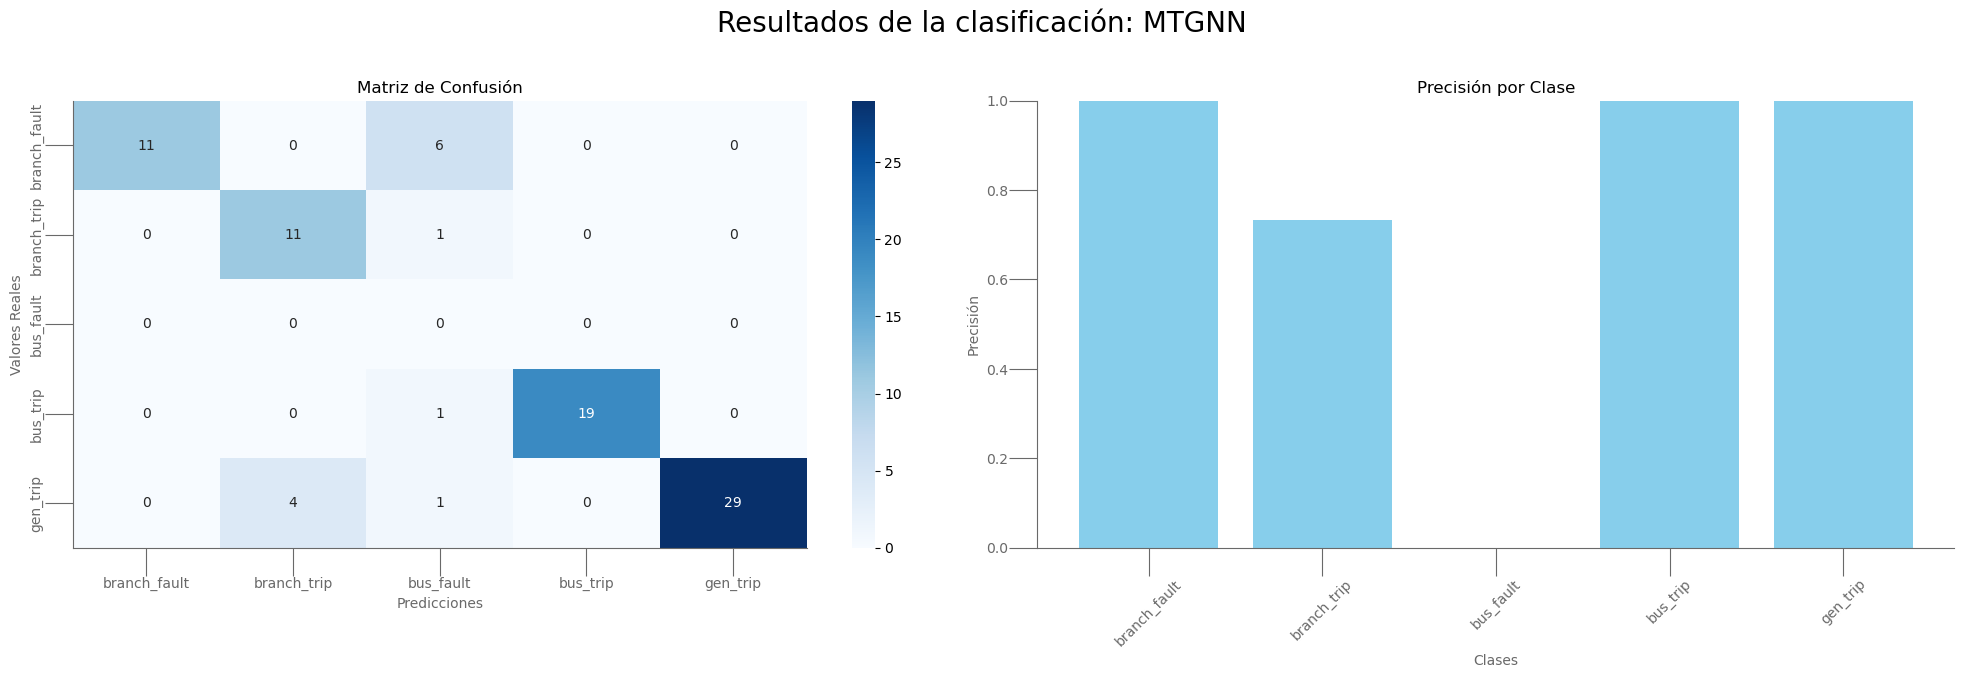

In [14]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "MTGNN")

In [15]:
name_model ="MTGNN"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0     MPNN_LSTM                {'Hidden Size': 64, 'Dropout': 0.2}   
1    LSTM_BATCH                  {'Hidden Size': 150, 'Layers': 1}   
2  LSTM_NOBATCH                  {'Hidden Size': 150, 'Layers': 2}   
3         AGCRN             {'hidden': 50, 'Embedding': 5, 'K': 2}   
4   DyGrEncoder  {'aggr': 'mean', 'conv': 2, 'lstm': 1, 'lstm_o...   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_...   
6         DCRNN                                     {'hidden': 60}   
7         MTGNN  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_...   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   
1  ../experimentos_split/results/clasificacion/aj...  1.163377   1.213140   
2  ../experimentos_split/results/clasificacion/aj...  1.160608   1.194841 